<a href="https://colab.research.google.com/github/mekaviraj/ML_sem5/blob/main/final_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import math


In [2]:

EPS = 1e-12

def minmax_scale(X):
    scaler = MinMaxScaler()
    Xs = scaler.fit_transform(X)
    return Xs, scaler

def build_bpa_from_scaled(X_scaled):
    """BPA vectors: m_i = x_i / sum(x_j)"""
    sums = X_scaled.sum(axis=1, keepdims=True)
    M = X_scaled / (sums + EPS)
    zero_mask = (sums.squeeze() == 0)
    if np.any(zero_mask):
        M[zero_mask] = 1.0 / X_scaled.shape[1]
    return M


In [3]:

def compute_feature_similarity_matrix(X_scaled):
    """Jaccard-like overlap: D[i,j] = sum(min(col_i, col_j)) / sum(max(col_i, col_j))"""
    n_features = X_scaled.shape[1]
    D = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        col_i = X_scaled[:, i]
        for j in range(n_features):
            col_j = X_scaled[:, j]
            num = np.sum(np.minimum(col_i, col_j))
            den = np.sum(np.maximum(col_i, col_j)) + EPS
            D[i, j] = num / den
    return D

def evidence_distance(m1, m2, D):
    """Compute evidence distance sqrt(0.5 * (m1-m2)^T D (m1-m2))"""
    diff = m1 - m2
    val = 0.5 * diff.dot(D).dot(diff)
    return math.sqrt(max(val, 0.0))


In [4]:

class EDKMeans:
    """K-Means using Evidence Distance."""
    def __init__(self, n_clusters=3, init='kmeans++', max_iter=100, tol=1e-4, random_state=None, pre_scale=True):
        assert init in ('random', 'kmeans++')
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = int(max_iter)
        self.tol = tol
        self.random_state = random_state
        self.pre_scale = pre_scale
        self.cluster_centers_ = None
        self.labels_ = None
        self.n_iter_ = 0
        self._scaler = None
        self._D = None

    def _init_centers(self, X, M):
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)

        if self.init == 'random':
            idx = rng.choice(n_samples, self.n_clusters, replace=False)
            return X[idx].astype(float)

        # kmeans++ style EDKMeans initialization
        centers_idx = []
        first = rng.randint(0, n_samples)
        centers_idx.append(first)
        centers_m = [M[first]]

        for _ in range(1, self.n_clusters):
            dists = np.array([
                min(evidence_distance(M[i], cm, self._D)**2 for cm in centers_m)
                for i in range(n_samples)
            ])

            if dists.sum() == 0:
                probs = np.ones_like(dists) / len(dists)
            else:
                probs = dists / dists.sum()

            r = rng.rand()
            cum = np.cumsum(probs)
            idx = int(np.searchsorted(cum, r))
            centers_idx.append(idx)
            centers_m.append(M[idx])

        return X[centers_idx].astype(float)

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n_samples, n_features = X.shape

        if self.pre_scale:
            Xs, scaler = minmax_scale(X)
            self._scaler = scaler
        else:
            Xs = X.copy()
            self._scaler = None

        M = build_bpa_from_scaled(Xs)
        self._D = compute_feature_similarity_matrix(Xs)

        centers = self._init_centers(X, M)
        labels = np.full(n_samples, -1, dtype=int)

        for it in range(self.max_iter):
            if self._scaler is not None:
                centers_scaled = self._scaler.transform(centers)
            else:
                centers_scaled = centers.copy()
            centers_M = build_bpa_from_scaled(centers_scaled)

            # Assignment step
            new_labels = np.empty(n_samples, dtype=int)
            for i in range(n_samples):
                dists = [evidence_distance(M[i], centers_M[j], self._D) for j in range(self.n_clusters)]
                new_labels[i] = int(np.argmin(dists))

            # Update step
            new_centers = np.zeros_like(centers)
            changed = False
            for k in range(self.n_clusters):
                members = (new_labels == k)
                if np.any(members):
                    new_centers[k] = X[members].mean(axis=0)
                else:
                    # empty cluster, reinitialize
                    rng = np.random.RandomState(self.random_state)
                    new_centers[k] = X[rng.randint(0, n_samples)]
                if np.linalg.norm(new_centers[k] - centers[k]) > self.tol:
                    changed = True

            centers = new_centers
            labels = new_labels
            self.n_iter_ = it + 1

            if not changed:
                break

        self.cluster_centers_ = centers
        self.labels_ = labels
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self._scaler is not None:
            Xs = self._scaler.transform(X)
        else:
            Xs = X.copy()
        M = build_bpa_from_scaled(Xs)

        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted.")

        if self._scaler is not None:
            centers_scaled = self._scaler.transform(self.cluster_centers_)
        else:
            centers_scaled = self.cluster_centers_.copy()
        centers_M = build_bpa_from_scaled(centers_scaled)

        labels = np.empty(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            dists = [evidence_distance(M[i], centers_M[j], self._D) for j in range(self.n_clusters)]
            labels[i] = int(np.argmin(dists))
        return labels


In [5]:

def demo_on_iris():
    X, y = load_iris(return_X_y=True)
    k_true = 3

    # Baseline sklearn KMeans
    baseline = KMeans(n_clusters=k_true, random_state=42, n_init=10)
    baseline_labels = baseline.fit_predict(X)

    # ED-KMeans (random init)
    ed_rand = EDKMeans(n_clusters=k_true, init='random', random_state=42)
    ed_rand.fit(X)
    ed_rand_labels = ed_rand.labels_

    # ED-KMeans (kmeans++-style for ED)
    ed_pp = EDKMeans(n_clusters=k_true, init='kmeans++', random_state=42)
    ed_pp.fit(X)
    ed_pp_labels = ed_pp.labels_

    def print_metrics(name, labels):
        ari = adjusted_rand_score(y, labels)
        sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else float('nan')
        print(f"{name:20s}  ARI: {ari:.4f}  Silhouette: {sil:.4f}")

    print_metrics("Baseline KMeans", baseline_labels)
    print_metrics("ED-KMeans (random)", ed_rand_labels)
    print_metrics("ED-KMeans (kmeans++)", ed_pp_labels)

    # Visualize clusters in 2D PCA
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].scatter(X2[:,0], X2[:,1], c=baseline_labels, cmap='tab10', s=30)
    axes[0].set_title("Baseline KMeans (PCA view)")
    axes[1].scatter(X2[:,0], X2[:,1], c=ed_rand_labels, cmap='tab10', s=30)
    axes[1].set_title("ED-KMeans (random init)")
    axes[2].scatter(X2[:,0], X2[:,1], c=ed_pp_labels, cmap='tab10', s=30)
    axes[2].set_title("ED-KMeans (kmeans++ init)")
    plt.show()



Baseline KMeans       ARI: 0.7302  Silhouette: 0.5528
ED-KMeans (random)    ARI: 0.4847  Silhouette: 0.3232
ED-KMeans (kmeans++)  ARI: 0.4567  Silhouette: 0.4187


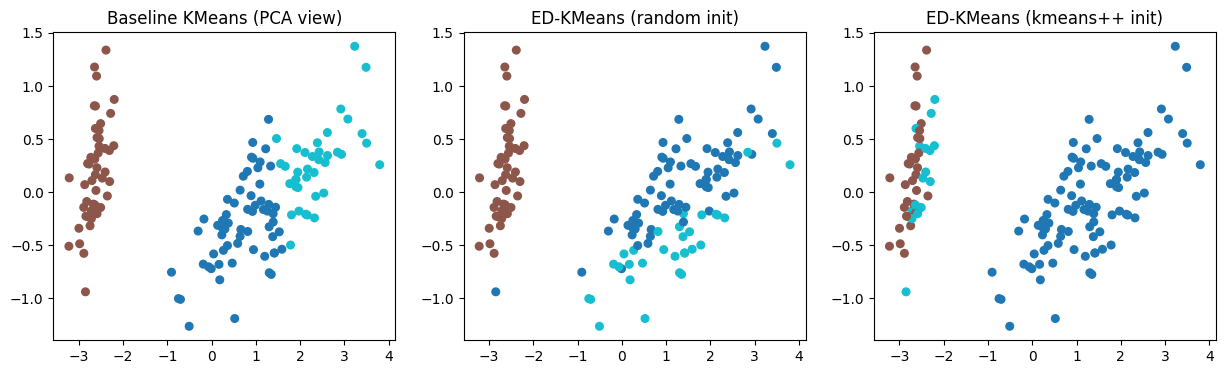

In [6]:
demo_on_iris()

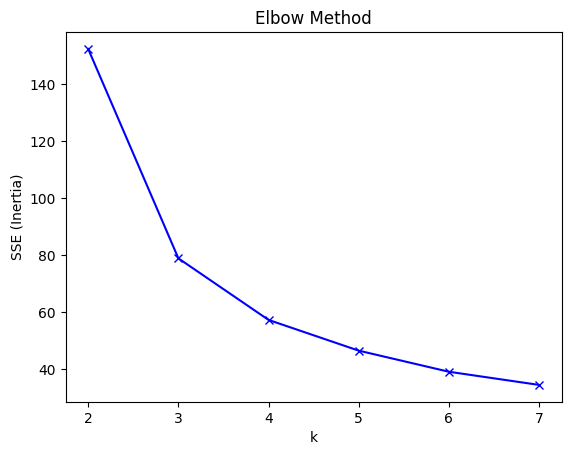

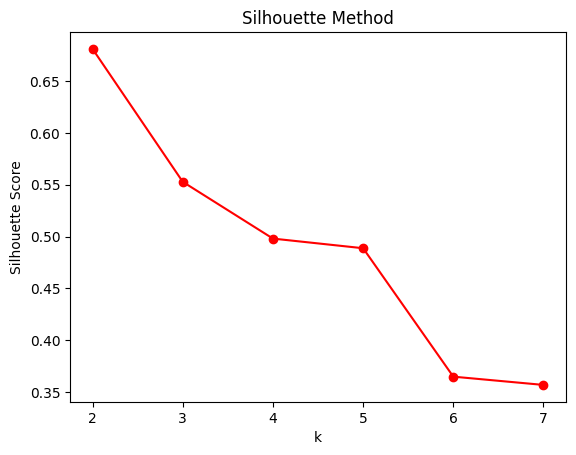

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X, y = load_iris(return_X_y=True)

# Elbow method
sse = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    sse.append(km.inertia_)
plt.plot(K, sse, 'bx-')
plt.xlabel("k")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")
plt.show()

# Silhouette method
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    sil.append(silhouette_score(X, km.labels_))
plt.plot(K, sil, 'ro-')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()